<a href="https://colab.research.google.com/github/aiAdrian/flatland_railway_extension/blob/master/Flatland_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🚂 The Flatland Dynamics Demo

Flatland Extension code base:
https://github.com/aiAdrian/flatland_railway_extension/blob/master/flatland_extensions/environment_extensions
 

In [1]:
from IPython.display import clear_output 
clear_output()

In [2]:
!git clone http://gitlab.aicrowd.com/flatland/flatland.git
%cd flatland
!git pull
%cd ..
!pip install -r /content/flatland/requirements_dev.txt &> /dev/null

Cloning into 'flatland'...
remote: Enumerating objects: 17027, done.
remote: Counting objects: 100% (565/565), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 17027 (delta 398), reused 512 (delta 352), pack-reused 16462
Receiving objects: 100% (17027/17027), 55.25 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (12737/12737), done.
/content/flatland
Already up to date.
/content


In [3]:
!git clone https://github.com/aiAdrian/flatland_railway_extension.git/
%cd flatland_railway_extension
!git pull
%cd ..

Cloning into 'flatland_railway_extension'...
remote: Enumerating objects: 571, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 571 (delta 180), reused 124 (delta 82), pack-reused 320
Receiving objects: 100% (571/571), 12.26 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (388/388), done.
/content/flatland_railway_extension
Already up to date.
/content


In [4]:
import os
import sys
os.environ['PYTHONPATH'] = "/env/python:/content/flatland:/content/flatland_railway_extension"
if "/content/flatland" not in sys.path:
  sys.path.insert(1, "/content/flatland")
if "/content/flatland_railway_extension" not in sys.path:
  sys.path.insert(1, "/content/flatland_railway_extension")

In [5]:
# import all flatland dependance
import time
import PIL
from IPython.display import display

from flatland.utils.rendertools import RenderTool
from flatland.envs.rail_env_action import RailEnvActions

import numpy as np
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env_action import RailEnvActions

from flatland_extensions.FlatlandEnvironmentHelper import FlatlandEnvironmentHelper
from flatland_extensions.RailroadSwitchAnalyser import RailroadSwitchAnalyser
from flatland_extensions.RailroadSwitchCluster import RailroadSwitchCluster
from flatland_extensions.environment_extensions.FlatlandDynamics import FlatlandDynamics
from flatland_extensions.environment_extensions.FlatlandResourceAllocator import FlatlandResourceAllocator
from flatland_extensions.environment_extensions.InfrastructureData import InfrastructureData
from flatland_extensions.utils.FlatlandRenderer import FlatlandRenderer



In [6]:
def render_env(env):
    env_renderer = RenderTool(env, gl="PGL")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    display(pil_image)

In [7]:
def create_infrastructure_data(env: RailEnv, railroad_switch_analyser : RailroadSwitchAnalyser) -> InfrastructureData:
    infrastructure_data = InfrastructureData()
    cell_length_grid = np.ones((env.height, env.width)) * 400
    gradient_grid = np.zeros((env.height, env.width))
    velocity_grid = np.ones((env.height, env.width)) * 100
    for key in railroad_switch_analyser.railroad_switch_neighbours.keys():
        velocity_grid[key] = 80
    for key in railroad_switch_analyser.railroad_switches.keys():
        velocity_grid[key] = 60
    infrastructure_data.set_infrastructure_max_velocity_grid(velocity_grid / 3.6)
    infrastructure_data.set_infrastructure_cell_length_grid(cell_length_grid)
    infrastructure_data.set_infrastructure_gradient_grid(gradient_grid)
    return infrastructure_data


In [8]:
 def run_simulation(flatland_environment_helper, railroad_switch_cluster, railroad_switch_analyser):
    env = flatland_environment_helper.get_rail_env()
    observations, info = env.reset()

    for agent in env.agents:
        agent.set_infrastructure_data(
            create_infrastructure_data(flatland_environment_helper.get_rail_env(), railroad_switch_analyser)
        )
        agent.rolling_stock.a_max_break = -0.15
        agent.set_mass(500)

    for step in range(1201):

        flatland_resource_allocator = FlatlandResourceAllocator(env=flatland_environment_helper.get_rail_env())
        flatland_environment_helper.get_rail_env().activate_flatland_resource_allocator(flatland_resource_allocator)
        flatland_environment_helper.get_rail_env().activate_railroad_switch_cluster_locking(railroad_switch_cluster)

        actions = {}
        for agent_handle in flatland_environment_helper.get_rail_env().get_agent_handles():
            obs = observations[agent_handle]
            actions.update({agent_handle: RailEnvActions(obs[0])})

        observations, all_rewards, dones, info = env.step(actions)

        for agent_handle in flatland_environment_helper.get_rail_env().get_agent_handles():
            env = flatland_environment_helper.get_rail_env()
            env.dev_obs_dict.update(
                {agent_handle: flatland_resource_allocator.get_assigned_resources(agent_handle=agent_handle)})
        
        if step % 1200 == 0 and step >0:
          render_env(env=flatland_environment_helper.get_rail_env())
 
        if dones["__all__"]:
            break  

In [9]:
flatland_environment_helper = FlatlandEnvironmentHelper(rail_env=FlatlandDynamics, random_seed=2341)
railroad_switch_analyser = RailroadSwitchAnalyser(env=flatland_environment_helper.get_rail_env())
railroad_switch_cluster = RailroadSwitchCluster(railroad_switch_analyser=railroad_switch_analyser)

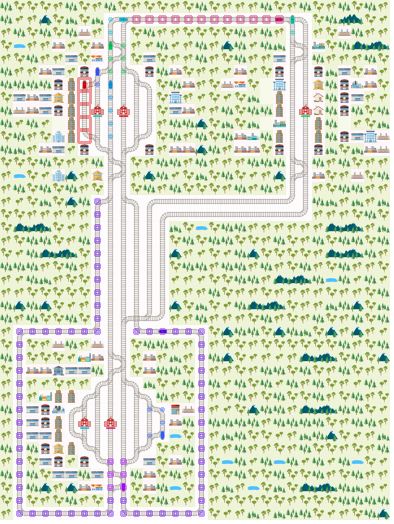

In [10]:
run_simulation(flatland_environment_helper, railroad_switch_cluster, railroad_switch_analyser)

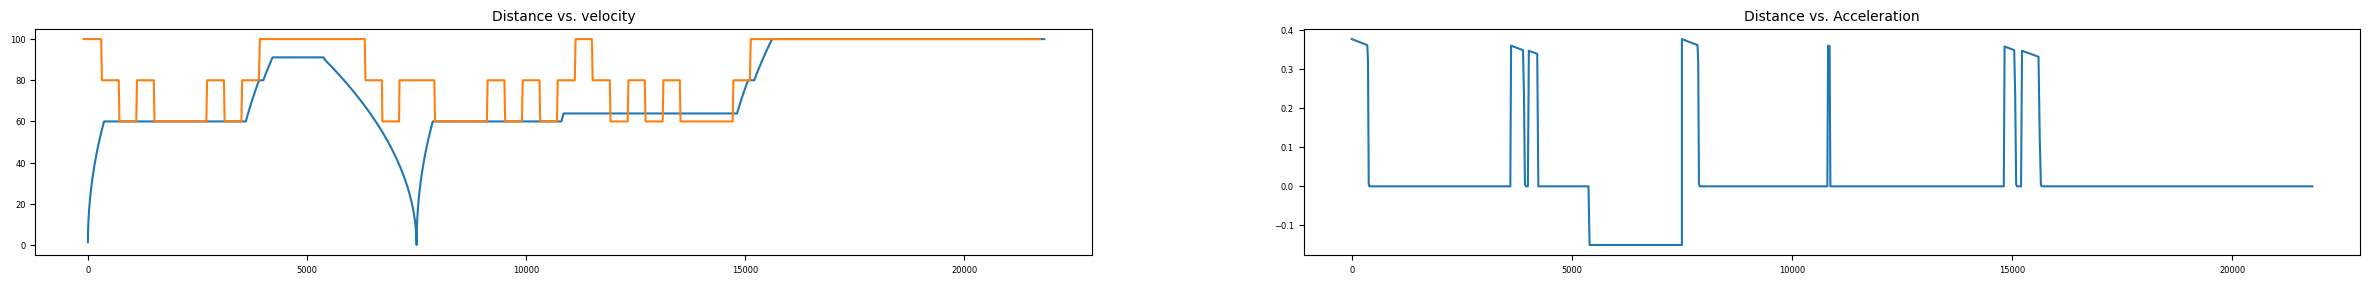

In [11]:
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [30, 3]
flatland_environment_helper.get_rail_env().agents[3].do_debug_plot(1, 1, True)

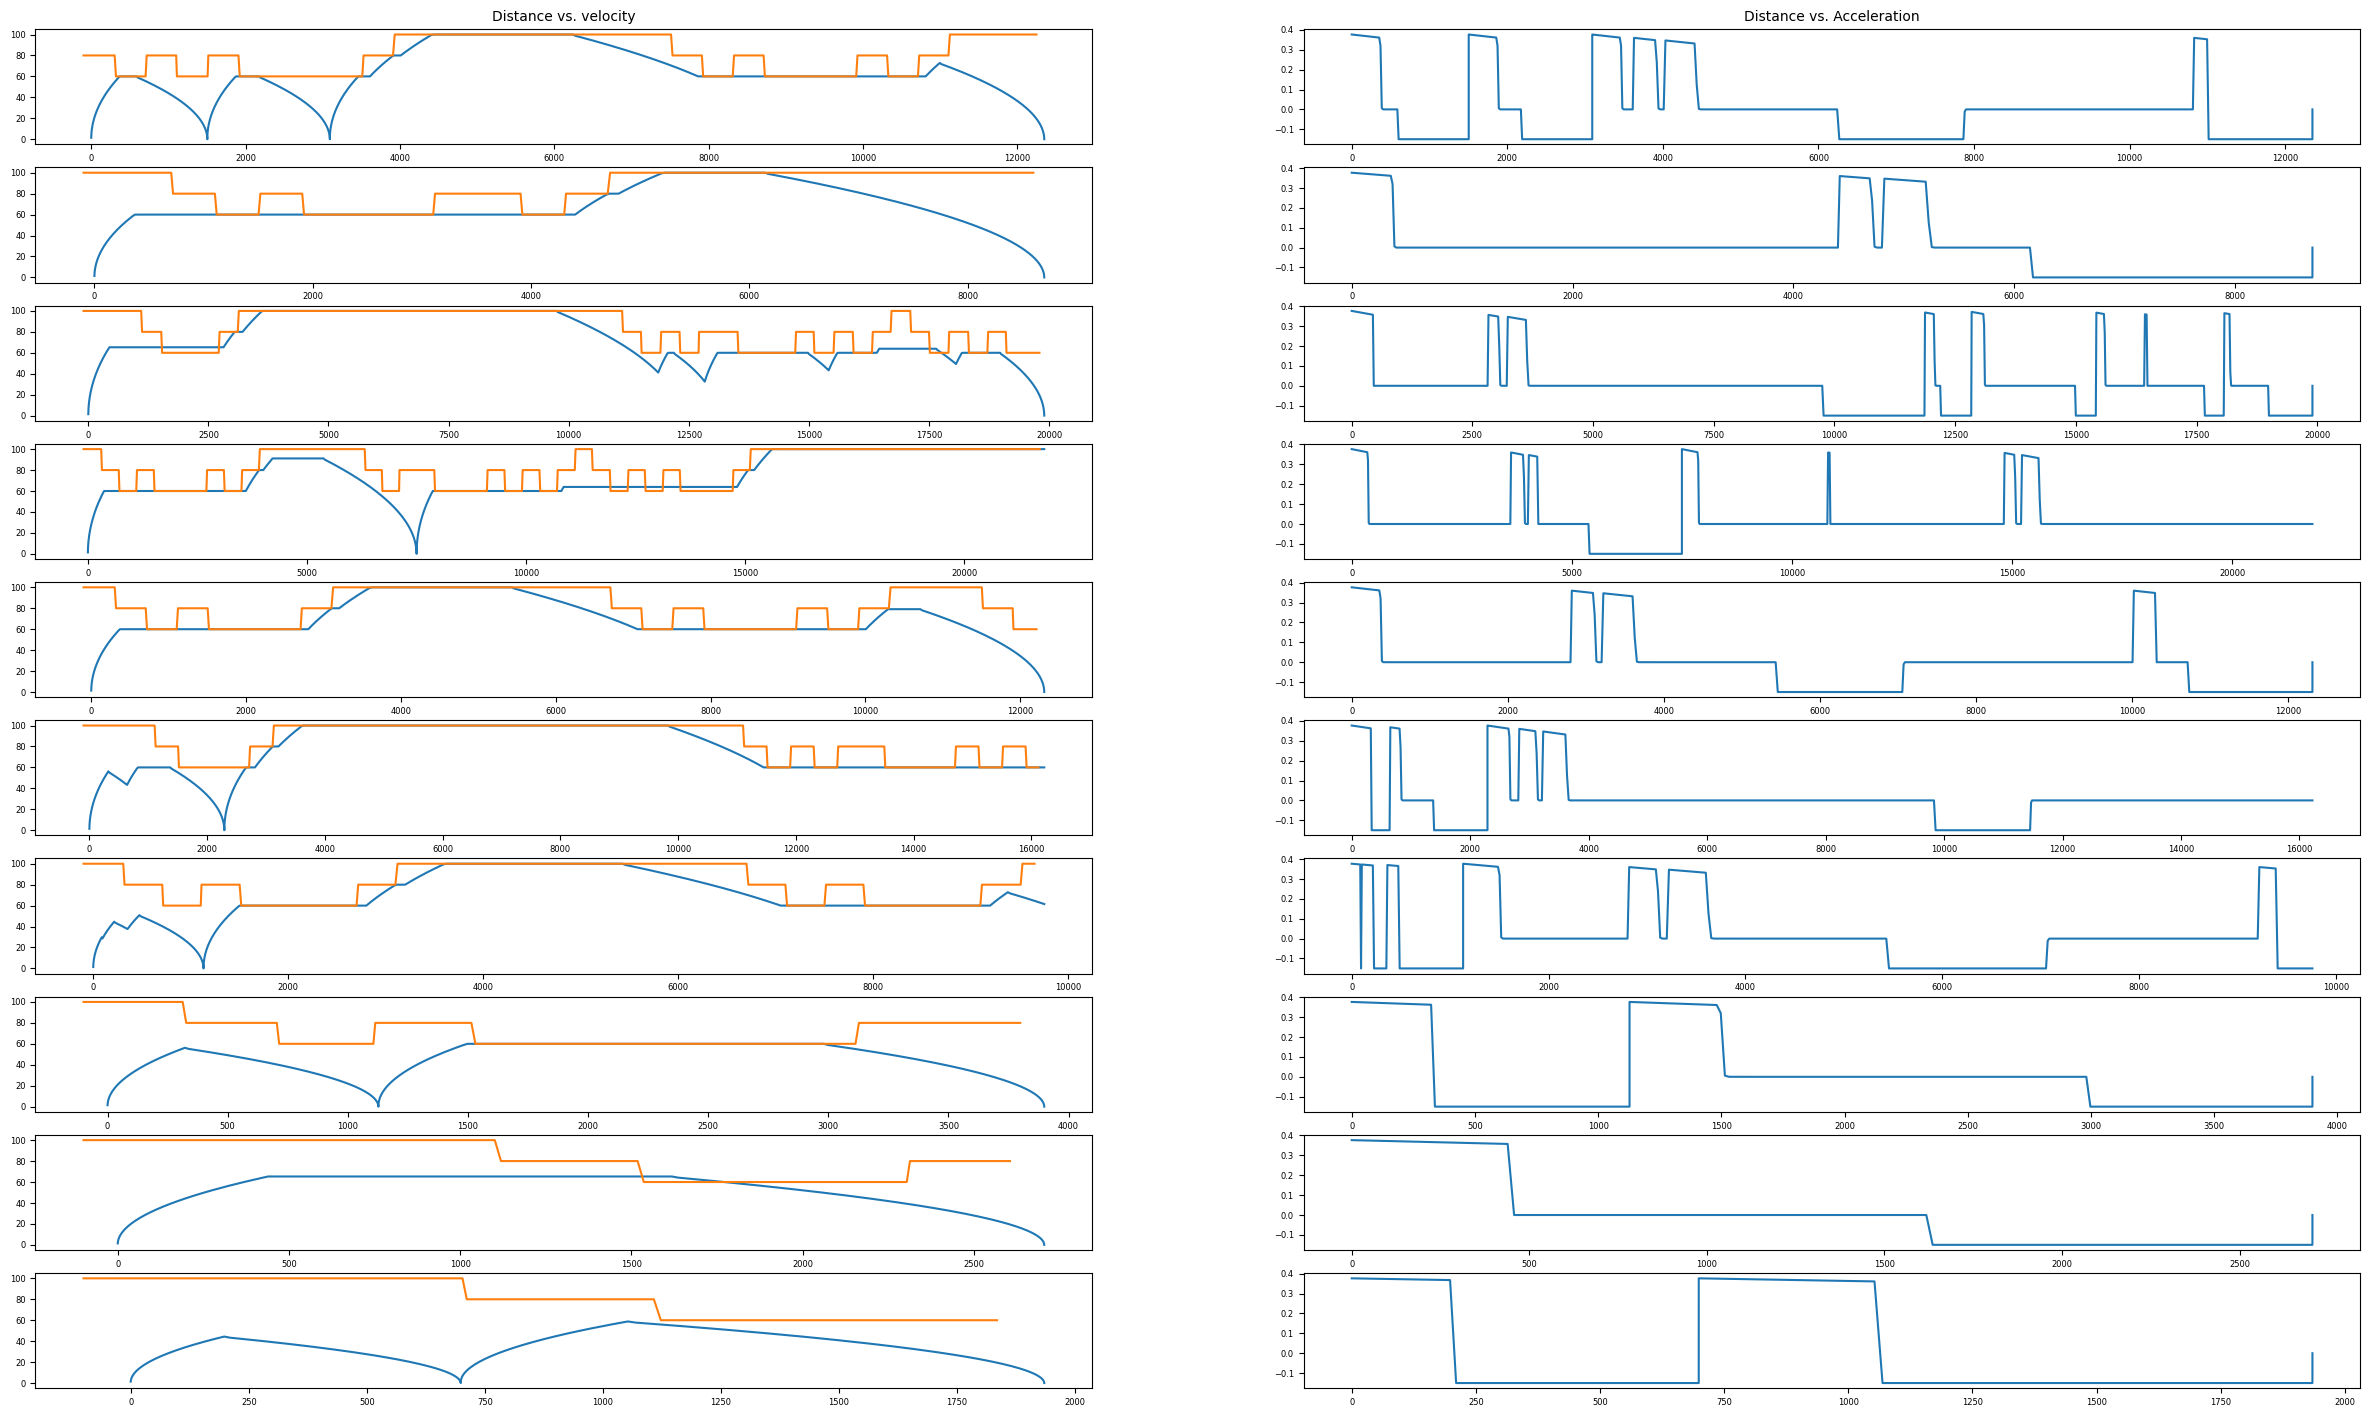

In [12]:
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [30, 18]
for i_agent, agent in enumerate(flatland_environment_helper.get_rail_env().agents):
        n_agents = flatland_environment_helper.get_rail_env().get_num_agents()
        show = i_agent + 1 == n_agents
        agent.do_debug_plot(i_agent + 1, n_agents, show, i_agent==0)


Author: Adrian Egli